# Imports

In [1]:
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import HTML
from tqdm import tqdm
import numpy as np
import pandas as pd
import mujoco
from scipy.optimize import minimize
from base64 import b64encode
import os
import skvideo.io


MyoSuite:> Registering Myo Envs


# Utils functions

In [2]:
def show_video(video_path, video_width = 1080):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

def read_opensim_cmc():
    """
    Read OpenSim CMC result and return uxxx and qxxx.
    """
    opensim_file = './data/9_Opensim_cmc.csv'
    df = pd.read_csv(opensim_file, skiprows=7, header=None)
    uxxx = df.iloc[:, 0:7].values
    qxxx = df.iloc[:, [0, 7, 8]].values 
    return uxxx, qxxx

def plot_qpos(all_qpos_myo, all_qpos_opensim=None, traj=None):
    '''
    compare myosuite and opensim cmc joint angle
    '''
    plt.figure(figsize=(8, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    line_styles = ['-', '--', ':']

    if traj is not None:
        plt.plot(traj[:, 0], traj[:, 1], 
                 color=colors[0], linestyle=line_styles[0], label='Reference')
        plt.plot(traj[:, 0], traj[:, 4], 
                 color=colors[0], linestyle=line_styles[0])

    plt.plot(all_qpos_myo[:, 0], all_qpos_myo[:, 1],
             color=colors[1], linestyle=line_styles[1], label='MyoSuite')
    plt.plot(all_qpos_myo[:, 0], all_qpos_myo[:, 2],
             color=colors[1], linestyle=line_styles[1])

    if all_qpos_opensim is not None:
        plt.plot(all_qpos_opensim[:, 0], all_qpos_opensim[:, 1],
                color=colors[2], linestyle=line_styles[2], label='OpenSim')
        plt.plot(all_qpos_opensim[:, 0], all_qpos_opensim[:, 2],
                color=colors[2], linestyle=line_styles[2])

    plt.xlabel('Time (s)')
    plt.ylabel('Joint Angle (rad)')
    plt.title('CMC Joint Angle Comparison: Reference vs MyoSuite vs OpenSim')
    plt.legend(loc='upper left')
    plt.grid(False)
    
    plt.ylim(0, 1.7)
    
    plt.tight_layout()
    plt.show() 

def plot_uxxx(uxxx_myo, uxxx_opensim, muscle_names):
    """
    compare myosuite and opensim cmc muscle ctrl
    """
    num_muscles = uxxx_myo.shape[1] - 1
    fig, axs = plt.subplots(2, 3, figsize=(8, 6))
    axs = axs.flatten()

    for j in range(num_muscles):
        ax = axs[j]
        ax.plot(uxxx_myo[:, 0], uxxx_myo[:, j+1], label='MyoSuite CMC')
        ax.plot(uxxx_opensim[:, 0], uxxx_opensim[:, j+1], label='OpenSim CMC')

        ax.set_xlim(0, 1)
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel(f'{muscle_names[j]} Activation') 
        ax.grid(False)

        if j == 0:
            ax.legend(loc='upper right', framealpha=0.8)

    plt.suptitle('Muscle Activation Comparison: MyoSuite CMC vs Opensim CMC')
    plt.tight_layout()
    plt.show()

# Introduction
In this tutorial a target trajectory will be replicated by MyoElbow (2 dof 6 muscles) using [Computed Muscle Control](<https://doi.org/10.1016/S0021-9290(02)00432-3>), given a sequence of joint angles, angular velocity, and angular acceleration $\theta_{exp}, \dot{\theta}_{exp}, \ddot{\theta}_{exp}$, a sequence of muscle control *u* will be generated. Meanwhile, the muscle control of the [arm26.osim](https://github.com/opensim-org/opensim-models/tree/master/Models/Arm26) model during the same motion were computed using OpenSim CMC for comparison.

<img src="https://picgo-liusiyuan.oss-cn-beijing.aliyuncs.com/picgo-lsy/202504161341857.png" alt="CMC" width="1000">

In [3]:
traj = pd.read_csv('data/9_joint_trajectory.csv').values

In [4]:
model0 = loader.get_sim(None, 'elbow/myoelbow_2dof6muscles.xml')  # for static optimization
model1 = loader.get_sim(None, 'elbow/myoelbow_2dof6muscles.xml')  # for forward dynamics

# First stage (Calculate desired acceleration)

$$
	\ddot{\theta}_d = \ddot{\theta}_{exp}+k_v(\dot{\theta}_{exp}-\dot{\theta})+k_p(\theta_{exp}-\theta)
\tag{1}
$$

$\theta_{exp}, \dot{\theta}_{exp}, \ddot{\theta}_{exp}$ are the reference joint angle, angular velocity, and angular acceleration, respectively.

$\theta, \dot{\theta}$ are the joint angle and angular velocity of the model at the current time step, respectively.

$k_v, k_p$ are the velocity gain and position gain, respectively. 

To make the errors converge to zero in a critically damped manner, $k_v = 2 \sqrt{k_p}$.

Here we set $k_p = 100$ and $k_v = 20$.

In [5]:
kp = 100
kv = 2*np.sqrt(kp)

def get_des_acc(data, exp_pos, exp_vel, exp_acc):
    # Get the desired acceleration
    q = data.qpos[:2]  
    qvel = data.qvel[:2]
    qacc_d = exp_acc + kv * (exp_vel - qvel) + kp * (exp_pos - q)
    return qacc_d

# Second stage (Static Optimaization)

For the static optimization problem, the performance criterion was chosen to be the sum of squared muscle activations:

$$
\min\sum_{m=1}^{N}(a_m^*)^2
$$
$$
\text{s.t. } \ddot{\theta^*}=\ddot{\theta_d}
$$
$$
0 \leq a_m \leq 1
\tag{2}
$$

In [6]:
def StaticOpt(model, data, qacc_d, max_iter=100):
    initial_state = np.concatenate([data.qpos, data.qvel])
    initial_act = data.act.copy()
    n_actuators = model.nu   

    def loss_fn(act):
        return 0.5 * np.sum(act**2)  

    def acceleration_constraint(act):
        mujoco.mj_resetData(model, data)
        data.qpos[:] = initial_state[:model.nq]
        data.qvel[:] = initial_state[model.nq:]
        data.act[:] = act
        mujoco.mj_step(model, data)
        return data.qacc[:2] - qacc_d 

    constraints = {
        'type': 'eq',
        'fun': acceleration_constraint,
        'tol': 1e-6
    }

    bounds = [(0, 1.0) for _ in range(n_actuators)]
    result = minimize(
        loss_fn,
        x0=initial_act,
        method='SLSQP', 
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': max_iter, 'disp': False}
    )
    return result.x, result

# Third Stage (Muscle excitations controller) 

$$
u = a^* + k_u (a^* - a)
\tag{3}
$$

$$
u = clip(0,1,u)
$$

$u$ is the muscle activation, $a^*$ is the optimal muscle activations computed in stage 2, and $a$ is the current muscle activations in forward dynamic simulation, $k_u$ is the feedback gain.

Here we set $k_u = 1$.

In [7]:
def compute_u(opt_a, act):
    ku = 1
    u = opt_a + ku * (opt_a - act)
    u = np.clip(u, 0, 1.0)
    return u

# Fourth Stage (Forward Dynamics)

In [8]:
all_qpos = np.zeros((traj.shape[0], 3))
all_ctrl = np.zeros((traj.shape[0], 1 + model1.nu)) 
data1 = mujoco.MjData(model1)

for idx in tqdm(range(traj.shape[0])):
    exp_pos = np.array([traj[idx, 1], traj[idx, 4]])
    exp_vel = np.array([traj[idx, 2], traj[idx, 5]])
    exp_acc = np.array([traj[idx, 3], traj[idx, 6]])
    
    qacc_d = get_des_acc(data1, exp_pos, exp_vel, exp_acc)

    data0 = deepcopy(data1)

    opt_a, result = StaticOpt(model0, data0, qacc_d, max_iter=100)

    u = compute_u(opt_a, data1.act)

    data1.ctrl = u
    mujoco.mj_step(model1, data1)
    all_qpos[idx,:] = np.hstack((data1.time, data1.qpos[:2])) 
    all_ctrl[idx,:] = np.hstack((data1.time, u))

100%|██████████| 501/501 [00:07<00:00, 63.42it/s]


Read OpenSim CMC data for comparison.

In [9]:
all_ctrl_opensim, all_qpos_opensim = read_opensim_cmc()

# Comparison: MyoSuite CMC vs OpenSim CMC

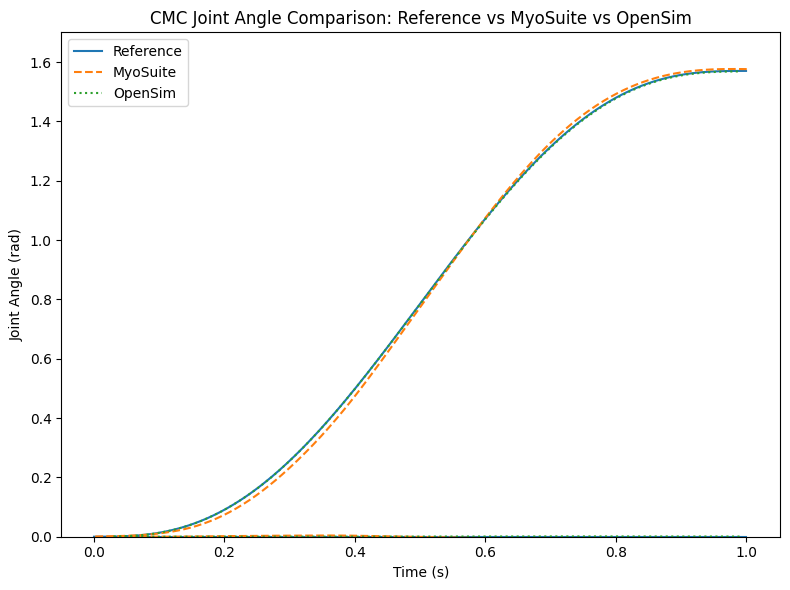

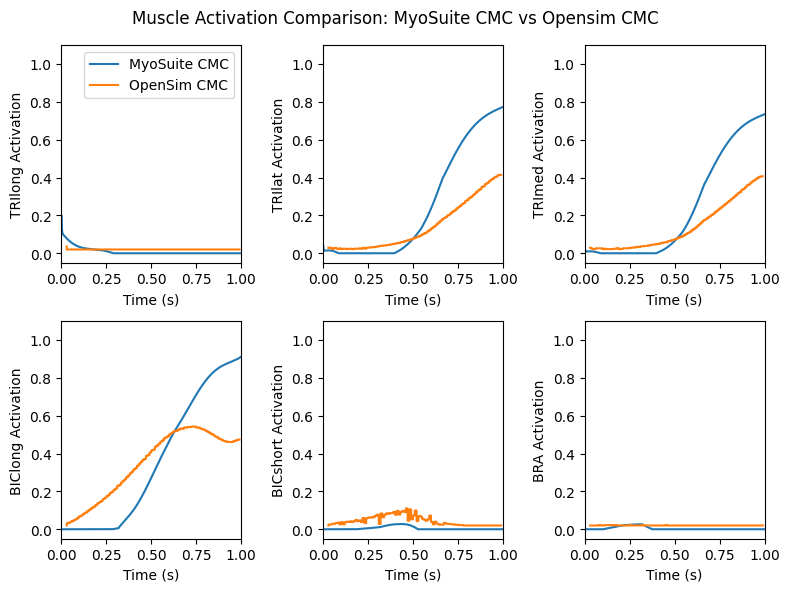

In [10]:
plot_qpos(all_qpos, all_qpos_opensim, traj)
muscle_names = [model1.actuator(i).name for i in range(model0.nu)]
plot_uxxx(all_ctrl, all_ctrl_opensim, muscle_names)

# Video Generalization

In [11]:
# ---- initializations
model_ref = loader.get_sim(None, 'elbow/myoelbow_2dof6muscles.xml')
data_ref = mujoco.MjData(model_ref) # data for reference trajectory
model_test = loader.get_sim(None, 'elbow/myoelbow_2dof6muscles.xml')
data_test = mujoco.MjData(model_test) # test data for achieved trajectory

camera = mujoco.MjvCamera()
camera.azimuth = 0
camera.distance =  1.1070990185160428
camera.elevation = -10.232281643227267
camera.lookat = np.array([-0.1130067696435806, 0.0815790401272094, 1.0655519045043413])

options_ref = mujoco.MjvOption()
options_ref.flags[:] = 0
options_ref.flags[[1, 22]] = 1
options_ref.geomgroup[2:] = 0

options_test = mujoco.MjvOption()
options_test.flags[:] = 0
options_test.flags[[1, 4, 22]] = 1
options_test.geomgroup[:] = 1

renderer_ref = mujoco.Renderer(model_ref, width=1080, height=1080)
renderer_ref.scene.flags[:] = 0

renderer_test = mujoco.Renderer(model_test, width=1080, height=1080)
renderer_test.scene.flags[:] = 0

frames = []
for idx in tqdm(range(traj.shape[0])):
    data_ref.qpos[:2] = [traj[idx, 1], traj[idx, 4]] 
    mujoco.mj_step1(model_ref, data_ref)
    data_test.ctrl = all_ctrl[idx, 1:]
    mujoco.mj_step(model_test, data_test)
    if not idx % round(0.3/(model_test.opt.timestep*25)):
        renderer_ref.update_scene(data_ref, camera=camera, scene_option=options_ref)
        frame_ref = renderer_ref.render()
        renderer_test.update_scene(data_test, camera=camera, scene_option=options_test)
        frame_test = renderer_test.render()
        frame_merged = np.append(frame_ref, frame_test, axis=1)
        frames.append(frame_merged)

os.makedirs('videos', exist_ok = True)
output_name = 'videos/myoelbow_freemovement.mp4'
skvideo.io.vwrite(output_name, np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})

100%|██████████| 501/501 [00:00<00:00, 997.37it/s] 


In [12]:
show_video(output_name)